## Tree-based model
- Linear models (e.g. linear regression, logistic regression)

In [1]:
import pandas as pd
from pandas_summary import DataFrameSummary
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline


In [3]:
data_dir = '_data/' 
df_train = pd.read_csv(data_dir + 'train.csv')
target_col = 'SalePrice'

def clean_na(df):
    # Pre-process - drop attributes that has no valid values for most of the records
    df = df.drop(['Alley', 'Fence','MiscFeature'], axis=1)

    # Drop Pool information as well as not many of the sampled properties has a pool (7 out of 1460)
    df = df.drop(['PoolArea', 'PoolQC'], axis=1)            
    return df.dropna()

df_train_no_na = clean_na(df_train)
# Find categorical variables
types_df = pd.DataFrame(df_train_no_na.dtypes).reset_index()
cat_cols = types_df[types_df[0] == 'object']['index'].values

In [5]:
from sklearn.model_selection import train_test_split 
from sklearn import metrics
from scipy import stats

def hot_encode_categorial_variables(df):
    return pd.get_dummies(df)

def predict_score(mymodel, xtrain, xtest, ytrain, ytest, verbose=True):
    mymodel.fit(xtrain, ytrain)
    #Predicting the prices
    pred = mymodel.predict(xtest)
    err_rms = np.sqrt(metrics.mean_squared_error(ytest, pred))/1000
    return err_rms
    
def split_predict_score(mymodel, df):
    X = df.drop(columns=target_col, axis=1)
    y = df[target_col].values
    xtrain, xtest, ytrain, ytest = train_test_split(X,y,test_size=1/4, random_state=0)
    err = predict_score(mymodel, xtrain, xtest, ytrain, ytest)
    print('Root Mean Squared Error (Scaled):', err)


In [11]:
from sklearn.linear_model import LinearRegression, LogisticRegression, Lasso, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier

print('\nAttempt 4: Decision Tree')
split_predict_score(DecisionTreeRegressor(max_depth=100), df_train_no_na.drop(columns=cat_cols, axis=1))

print('\nAttempt 4a: Decision Tree with categorical variables')
split_predict_score(DecisionTreeRegressor(max_depth=100), hot_encode_categorial_variables(df_train_no_na))



Attempt 4: Decision Tree
Root Mean Squared Error (Scaled): 50.54772023503042

Attempt 4a: Decision Tree with categorical variables
Root Mean Squared Error (Scaled): 55.77911930061333


**RMS error is higher than than using Ridge regression.  Again, this suggests this dataset is noisy and prone to over-fitting and tree-based models tend to overfit.  Let's try using random forest with a large number of trees to reduce the likelihood of overfitting**

In [12]:
print('\nAttempt 5: Random forest')
split_predict_score(RandomForestClassifier(n_estimators=100), hot_encode_categorial_variables(df_train_no_na))



Attempt 5: Random forest
Root Mean Squared Error (Scaled): 53.10536411494437


**Random forest didn't perform any better than decision tree either.  Let's have a look at the relationship between model parameters and errors**

## N Estimators (Number of trees in the forest)

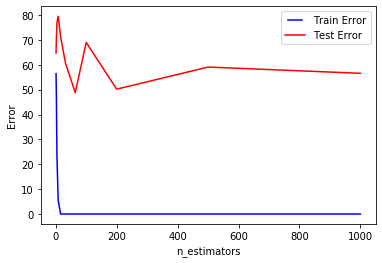

In [13]:
X = hot_encode_categorial_variables(df_train_no_na).drop(columns=target_col, axis=1)
y = df_train_no_na[target_col].values
xtrain, xtest, ytrain, ytest = train_test_split(X,y,test_size=1/4, random_state=0)

n_estimators = [1, 2, 4, 8, 16, 32, 64, 100, 200, 500, 1000]
train_results = []
test_results = []
for estimator in n_estimators:
   rf = RandomForestClassifier(n_estimators=estimator, n_jobs=-1)
   rf.fit(xtrain, ytrain)
   train_pred = rf.predict(xtrain)
   err_train = np.sqrt(metrics.mean_squared_error(ytrain, train_pred))/1000
   train_results.append(err_train)

   test_pred = rf.predict(xtest)
   err_pred = np.sqrt(metrics.mean_squared_error(ytest, test_pred))/1000
   test_results.append(err_pred)
    
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(n_estimators, train_results, 'b', label="Train Error")
line2, = plt.plot(n_estimators, test_results, 'r', label="Test Error")
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('Error')
plt.xlabel('n_estimators')
plt.show()

## Max Depth

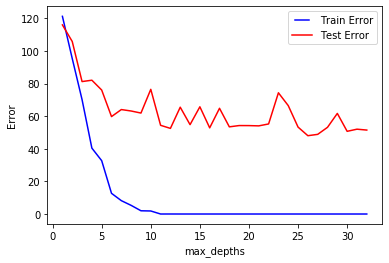

In [14]:
max_depths = np.linspace(1, 32, 32, endpoint=True)
train_results = []
test_results = []
for max_depth in max_depths:
   rf = RandomForestClassifier(n_estimators=200, max_depth=max_depth, n_jobs=-1)
   rf.fit(xtrain, ytrain)
   train_pred = rf.predict(xtrain)
   err_train = np.sqrt(metrics.mean_squared_error(ytrain, train_pred))/1000
   train_results.append(err_train)

   test_pred = rf.predict(xtest)
   err_pred = np.sqrt(metrics.mean_squared_error(ytest, test_pred))/1000
   test_results.append(err_pred)
    
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(max_depths, train_results, 'b', label="Train Error")
line2, = plt.plot(max_depths, test_results, 'r', label="Test Error")
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('Error')
plt.xlabel('max_depths')
plt.show()

**Training error is low while testing error is high suggests 1) overfitting or/and 2) dataset is not representative of the population
Let's try a higher training-to-testing sample ratio**


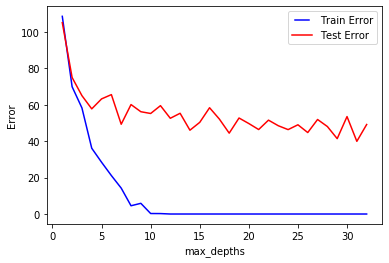

In [15]:
X = hot_encode_categorial_variables(df_train_no_na).drop(columns=target_col, axis=1)
y = df_train_no_na[target_col].values
xtrain, xtest, ytrain, ytest = train_test_split(X,y,test_size=1/8, random_state=0)
max_depths = np.linspace(1, 32, 32, endpoint=True)
train_results = []
test_results = []
for max_depth in max_depths:
   rf = RandomForestClassifier(n_estimators=200, max_depth=max_depth, n_jobs=-1)
   rf.fit(xtrain, ytrain)
   train_pred = rf.predict(xtrain)
   err_train = np.sqrt(metrics.mean_squared_error(ytrain, train_pred))/1000
   train_results.append(err_train)

   test_pred = rf.predict(xtest)
   err_pred = np.sqrt(metrics.mean_squared_error(ytest, test_pred))/1000
   test_results.append(err_pred)
    
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(max_depths, train_results, 'b', label="Train Error")
line2, = plt.plot(max_depths, test_results, 'r', label="Test Error")
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('Error')
plt.xlabel('max_depths')
plt.show()

**Only slightly better results but still a significant difference between the training error and test error.  I remember the distribution of SalePrice is fairly skewed, let's check if there is a correlation between the SalePrice and error**


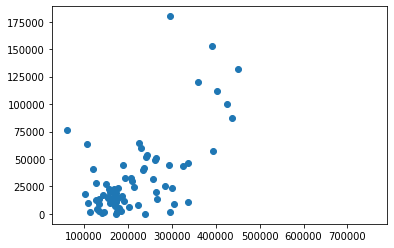

In [37]:
y_error = np.abs(test_pred - ytest)
plt.scatter(ytest, y_error)

# X-Axis is Sale price, y-axis is error

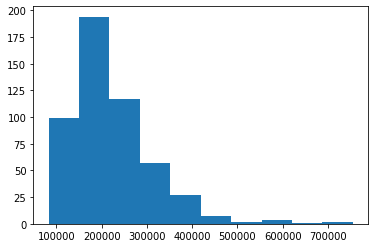

In [36]:
p = plt.hist(ytrain)
# Sample distribution is skewed to the left and that explains the high error rate for higher price properties.  
# There are not enough samples to accurately classify higher price properties